# Predict frame is voiced or unvoiced

In [1]:
import numpy as np
import h5py
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
%pylab inline

import matplotlib

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Keras model
* DNN with relu activation, no dopout layer
* 2 output if the frame is voiced 1, 0 else 0, 1

In [2]:
hidden_layers = 6

In [3]:
model = Sequential()
model.add(Dense(512, input_dim=215, activation='relu'))
for i in range(0,hidden_layers):
    model.add(Dense(512, activation='relu'))
model.add(Dense(2))

model.summary()        

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 512)           110592      dense_input_1[0][0]              
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 512)           262656      dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 512)           262656      dense_2[0][0]                    
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 512)           262656      dense_3[0][0]                    
___________________________________________________________________________________________

In [4]:
model.compile(optimizer=SGD(lr=0.1), loss='mse', metrics=['accuracy'])

prepare training data, targets convert ot 1, 0 and 0, 1 

In [5]:
data = []
with h5py.File('preprocessed_data/train-standardized.h5','r') as hf:
    data = np.array(hf.get('dataset'))
input_data = data[:,0:215]
print(input_data.shape)
target_data = data[:,215:216]
target_data2 = []
for i in range(0,len(target_data)):
    if (target_data[i] > 0):
        target_data2.append([1,0])
    else:
        target_data2.append([0,1])
print(target_data.shape)

(216559, 215)
(216559, 1)


Rescale de validation and test inputs similar to the training data

In [6]:
def fix_input(data, columns, mean, std):
    column_av = np.array(mean)
    column_std = np.array(std)
    a = np.array(data)
    new_matrix = (a-column_av[np.newaxis,:])/column_std[np.newaxis,:]
    
    b = np.array(columns)
    ret = (a*(1-b[np.newaxis,:]))+(new_matrix*(b[np.newaxis,:]))
    return ret

In [7]:
mean_ = []
with h5py.File('preprocessed_data/train-mean.h5','r') as hf:
    mean_ = np.array(hf.get('dataset'))
std_ = []
with h5py.File('preprocessed_data/train-std.h5','r') as hf:
    std_ = np.array(hf.get('dataset'))
test = []
columns_ = np.zeros((243))
for i in range(200,215):
    columns_[i] = 1  

In [8]:
data_validation = []
with h5py.File('preprocessed_data/validation.h5','r') as hf:
    data_validation = np.array(hf.get('dataset'))
data_validation = fix_input(data=data_validation, columns=columns_, mean=mean_, std=std_)
input_validation = data_validation[:,0:215]
print(input_validation.shape)
target_validation = data_validation[:,215:216]
target_validation2 = []
for i in range(0,len(target_validation)):
    if (target_validation[i] > 0):
        target_validation2.append([1,0])
    else:
        target_validation2.append([0,1])

(12594, 215)


### Learning, fix 410 epoch
(accuracy and loss for the validation data is not correct, but after the train we tested the network with new data

In [9]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir='log_uv', histogram_freq=0, write_graph=True, write_images=False)

In [10]:
model.fit(input_data, target_data2, nb_epoch=410, batch_size=1024,shuffle=True, verbose=0,
              validation_data=(input_validation, target_validation2), callbacks=[tensorboard_callback])

In [11]:
model.save('models_data/model_uv.h5')
model.save_weights('models_data/model_uv_weights.h5')

Load test data

In [12]:
with h5py.File('preprocessed_data/test.h5','r') as hf:
    test = np.array(hf.get('dataset')) 
test = fix_input(data=test, columns=columns_, mean=mean_, std=std_)

In [13]:
test_input = test[:,0:215]
test_target = test[:,215:216]

In [14]:
test_target.shape

(12249, 1)

In [15]:
test_target2 = []
for t in test_target:
    if (t[0] > 0):
        test_target2.append([1,0])
    else:
        test_target2.append([0,1])

In [16]:
evaulate_data = model.evaluate(test_input, test_target2, batch_size=32, verbose=1, sample_weight=None)

12192/12249 [============================>.] - ETA: 0s

In [20]:
evaulate_data

[0.15604405248325903, 0.83427218548452931]

In [21]:
output_test = []
for test in test_input[0:2000]:
    test = np.array(test)
    test = test.reshape(1,215)
    output_test.append(model.predict(test))

### Test

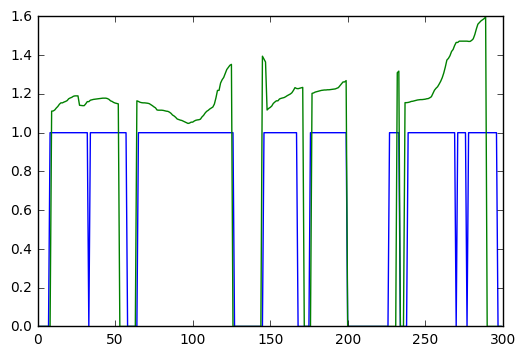

In [22]:
for o in output_test:
    if o[0][0] > o[0][1]:
        o[0][0] = 1
    else:
        o[0][0] = 0
output_test = np.array(output_test[0:300])[:,:,0]
output_test.shape
output_test = output_test.reshape(len(output_test))

plot(output_test)

targets = np.array(test_target)[:,0]
targets.shape
plot(targets[0:300]/100)